# Neural Networks

Let's do a quick tour of neural networks with MNIST and PyTorch.

MNIST is a toy dataset containing digit images of 28x28 in gray scale. 
For more infos about MNIST take a look the Lecun's [page](http://yann.lecun.com/exdb/mnist/) with some decription and results of differents architectures...

This notebook will be longer than the previous ones and will not cover all can do neural nets... just to have a quick look...
Here is the list of what it contains :

- linear network
- fully connected network with one hidden layer
- lenet like convolutionnal network
- activation map with fully convolutionnal network
- autoencoder
- transfert learning


## Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms

import glob
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

DEVICE = 'cpu'
BATCH_SIZE = 16
NB_CLASSES = 10
SIZE = 28

## Dataset

Download the data and load the datasets...

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '.',                                            #download in the current directory
        train = True,                                   #donwload the training base
        download = True,                                #allow downloading if not already downloaded
        transform = transforms.Compose([                #operations applied on the images before passing to the NN
            transforms.ToTensor(),                      #just convert the image into a tensor (required)
            transforms.Normalize((0.1307,), (0.3081,))  #normalize the image with mean and variance
        ])
    ),
    batch_size=BATCH_SIZE,                              #set the batch size (explicit enought I think...)
    shuffle=True                                        #allow the dataset to be shuffled
)

test_loader = torch.utils.data.DataLoader(              #same thing for the test
    datasets.MNIST(
        '.',
        train = False,                                  #load the test set
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

## Fully Connected Networks

### Linear classifier

Let's build the simplest linear classifier we can to get firsts results...

In [3]:
class LinearClassifier(nn.Module):
    def __init__(self, nb_classes=10):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(784, nb_classes),            #784 because 28x28, from 784 input to nb_classes output
            nn.Softmax(1)                          #1 to tell on wich dimension perform the softmax normalization
        )
        
    def forward(self, x):
        return self.linear(x)
    

In [4]:
linear_model = LinearClassifier(NB_CLASSES)              #instanciate the model
optimizer = optim.Adam(list(linear_model.parameters()))  #create an optimizer
loss_function = nn.CrossEntropyLoss()                    #create a loss function (multiclass -> cross entropy)

print(linear_model)                                      #quick look to our naive model

LinearClassifier(
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Softmax()
  )
)


1.5847845896621424	1.5535694567056804
1.5490066641392661	1.5443987655333984
1.5428013549419555	1.54133180471567
1.5387446962060467	1.5413843374221752
1.5363105302112647	1.5381035099808986
1.5340817328229464	1.5384795104081814
1.53252917761865	1.5374903560448916
1.5313446675977507	1.5363162838113613
1.5298791643650445	1.5394402524599662
1.528951072826421	1.5354954199149058
1.528437056996785	1.5332646031792347
1.5274375593798992	1.5354130331140299
1.5269193676319972	1.534111615939018
1.5259264945729505	1.5357670285380804
1.525558115991474	1.5383317281420414
1.5245640510939127	1.5352086976934702
1.5244100777490452	1.5344470206361551
1.5234215953694117	1.5333398926334503
1.5234022495682382	1.5333608127175233
1.5228304640710688	1.5338872071260061


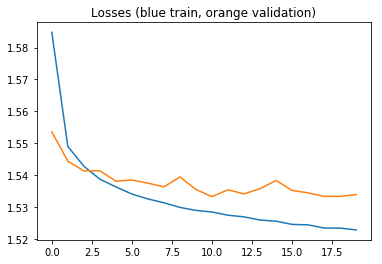

In [5]:
loss_history = []                                            #to record the training loss
loss_history_val = []                                        #to record the testing  loss

for epochs in range(20):                                     #let's run on 20 epochs
    #training
    linear_model = linear_model.train()                      #put our model in training mode (allow learning)
    mean_loss = 0.                                           #to compute the mean loss
    for i, (x, y) in enumerate(train_loader):                #load by batches the Xs and label associated
        if x.shape[0] != BATCH_SIZE:                         #just checking the batch size is good
            continue
        x = x.view([BATCH_SIZE, SIZE * SIZE]).to(DEVICE)     #reshape the data to match the network input size
        y = y.to(DEVICE)                                     #putting the labels on the device (cpu or cuda, just to be generic)
        pred = linear_model(x)                               #compute the model predictions for one batch
        loss = loss_function(pred, y)                        #compute the loss for one batch
        mean_loss += loss.item()                             #actualise the mean loss
        optimizer.zero_grad()                                #reseting the gradient of the previous iteration
        loss.backward()                                      #accumulate the gradient
        optimizer.step()                                     #update parameters
    mean_loss /= float(i)                                    #compute the mean loss
    loss_history.append(float(mean_loss))
    print(mean_loss, end='\t')
    
    #validation
    linear_model = linear_model.eval()                       #put the network in eval mode
    mean_loss_val = 0.
    for i, (x, y) in enumerate(test_loader):
        if x.shape[0] != BATCH_SIZE:
            continue
        x = x.view([BATCH_SIZE, SIZE * SIZE]).to(DEVICE)
        y = y.to(DEVICE)
        pred = linear_model(x)
        loss = loss_function(pred, y)
        mean_loss_val += loss.item()
    mean_loss_val /= float(i)
    loss_history_val.append(float(mean_loss_val))
    print(mean_loss_val)
        
plt.title("Losses (blue train, orange validation)")
plt.plot(loss_history)
plt.plot(loss_history_val)
plt.show()


In [6]:
#compute accuracy
linear_model = linear_model.eval()
acc = 0.
for i, (x, y) in enumerate(test_loader):
    x = x.view([BATCH_SIZE, SIZE * SIZE]).to(DEVICE)
    y = y.to(DEVICE)
    pred = linear_model(x)
    acc += (pred.max(1)[1] == y).detach().numpy().sum() / float(BATCH_SIZE)
acc /= i
print("accuracy :", acc, "%")

accuracy : 0.9313902243589743 %


Not so bad, but it's well know that MNIST is only a toy dataset with which one you can super easily get good scores...

So, let's try to improve our score by adding an hidden layer... it's still not 100% ! 😉

### One hidden unit network

In [7]:
class FullyConnectedNeuralNetwork(nn.Module):
    def __init__(self, nb_classes=10):
        super(FullyConnectedNeuralNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(784, 300),                           #let's put randomly 300 neurons in the hidden unit
            nn.ReLU(),                                     #let's add some non linearity with ReLU
            nn.Linear(300, nb_classes),                    #from 300 HU to nb_classes
            nn.Softmax(1)
        )
        
    def forward(self, x):
        return self.fc(x)

In [8]:
fc_classifier = FullyConnectedNeuralNetwork(NB_CLASSES)   #instanciate the model
optimizer = optim.Adam(list(fc_classifier.parameters()))  #create an optimizer
loss_function = nn.CrossEntropyLoss()                     #create a loss function (multiclass -> cross entropy)

print(fc_classifier)                                      #quick look to our naive model

FullyConnectedNeuralNetwork(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=10, bias=True)
    (3): Softmax()
  )
)


1.5550961481408776	1.5134064568540988
1.5088826850052675	1.5115396600121107
1.5009958288389131	1.502725855089151
1.4962803600119985	1.4957845977101571
1.4929661700871188	1.4998048419753711
1.4906773120125125	1.4952854850353339
1.4882213122115258	1.496836666877453
1.4869863144649955	1.4935283104960735
1.4863471271960569	1.4947567754066908
1.4849567496321874	1.496338997131739


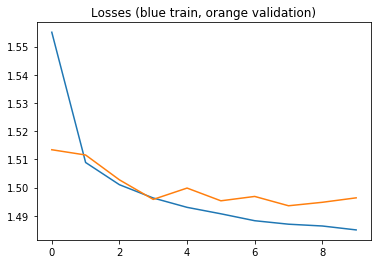

In [9]:
loss_history = []                                            #to record the training loss
loss_history_val = []                                        #to record the testing  loss

for epochs in range(10):                                     #let's run on 10 epochs
    #training
    fc_classifier = fc_classifier.train()                    #put our model in training mode (allow learning)
    mean_loss = 0.                                           #to compute the mean loss
    for i, (x, y) in enumerate(train_loader):                #load by batches the Xs and label associated
        if x.shape[0] != BATCH_SIZE:                         #just checking the batch size is good
            continue
        x = x.view([BATCH_SIZE, SIZE * SIZE]).to(DEVICE)     #reshape the data to match the network input size
        y = y.to(DEVICE)                                     #putting the labels on the device (cpu or cuda, just to be generic)
        pred = fc_classifier(x)                              #compute the model predictions for one batch
        loss = loss_function(pred, y)                        #compute the loss for one batch
        mean_loss += loss.item()                             #actualise the mean loss
        optimizer.zero_grad()                                #reseting the gradient of the previous iteration
        loss.backward()                                      #accumulate the gradient
        optimizer.step()                                     #update parameters
    mean_loss /= float(i)                                    #compute the mean loss
    loss_history.append(float(mean_loss))
    print(mean_loss, end='\t')
    
    #validation
    fc_classifier = fc_classifier.eval()                      #put the network in eval mode
    mean_loss_val = 0.
    for i, (x, y) in enumerate(test_loader):
        if x.shape[0] != BATCH_SIZE:
            continue
        x = x.view([BATCH_SIZE, SIZE * SIZE]).to(DEVICE)
        y = y.to(DEVICE)
        pred = fc_classifier(x)
        loss = loss_function(pred, y)
        mean_loss_val += loss.item()
    mean_loss_val /= float(i)
    loss_history_val.append(float(mean_loss_val))
    print(mean_loss_val)
        
plt.title("Losses (blue train, orange validation)")
plt.plot(loss_history)
plt.plot(loss_history_val)
plt.show()


In [10]:
#compute accuracy
fc_classifier = fc_classifier.eval()
acc = 0.
for i, (x, y) in enumerate(test_loader):
    x = x.view([BATCH_SIZE, SIZE * SIZE]).to(DEVICE)
    y = y.to(DEVICE)
    pred = fc_classifier(x)
    acc += (pred.max(1)[1] == y).detach().numpy().sum() / float(BATCH_SIZE)
acc /= i
print("accuracy :", acc, "%")

accuracy : 0.9683493589743589 %


Wahouuu !! much better score 😃 !!

But, event if it worked well, just putting one hidden unit is absolutely not enoughts on real world images (enven on CIFAR10)... 😞 it'll add too many parameters and start to overfit...

Also, even if we could stop here, we will see what revolutionnized the image wolds bellow ! 😍


___Exercice___: _try to code a network with 784 inputs, 50 neurons in the first hidden layer, 20 neurons in the second hidden layer and 10 ouputs, then test it on MNIST_...

## ConvNet

Neural networks are pretty old, but since 2012 there is a huge growth of interest since _AlexNet_ (an very fat neural network) won the ImageNet challenge by dropping the error from 26 to 16 (a very very huge improvment).

The secret of the modern networks for images (not anymore a sercret for anybody) is the convolution ! 
This operation allow us to add more layer with much fewer parameters and help the network to generalize much more... ✅

Let's start first to implement a very simple network : the LeNet architecture.

![lenet](./imgs/lenet.png)

The size will not be exactly the sames because our images are 28x28 instead of 32x32 like in the picture...

In [11]:
class LeNet(nn.Module):
    def __init__(self, nb_classes=10):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=1), #1 input channel (grayscale), 6 filters (= 6 outputs channnels), filter size 5
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),          #reduce the channels output size by 2 (taking the max between 2 adjacent pixels)
            nn.Conv2d(6, 15, 3),           #6 inputs, 15 ouputs
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(15, 15, 3), 
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(135, nb_classes),    #put a fully connected layer at the end of the conv features extraction
            nn.Softmax(1)
        )
        
    def forward(self, x):
        out = self.conv(x)                  #extract the conv features
        out = out.reshape(out.size(0), -1)  #flatten before passing to fully connected
        out = self.fc(out)                  #classify
        return out
        


In [12]:
le_net = LeNet(NB_CLASSES)   
optimizer = optim.Adam(list(le_net.parameters()))  
loss_function = nn.CrossEntropyLoss()                 

print(le_net)           

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 15, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=135, out_features=10, bias=True)
    (1): Softmax()
  )
)


1.6198988166228077	1.579564067415702
1.5797774481690703	1.5731017616314766
1.5747388720862163	1.5718721881126747
1.569176912752906	1.4924637352426846
1.4876777019205651	1.486641909640569
1.4837091723325317	1.4828016377794437
1.4820351683320794	1.4888047297031453
1.4810152656079991	1.4804989850291839
1.4811685546998121	1.4830226649840672
1.4813290414698252	1.4830358225183609


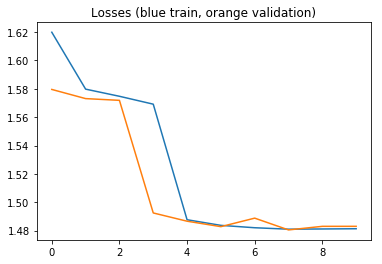

In [13]:
loss_history = []                                            #to record the training loss
loss_history_val = []                                        #to record the testing  loss

for epochs in range(10):                                     #let's run on 10 epochs
    #training
    le_net = le_net.train()                                  #put our model in training mode (allow learning)
    mean_loss = 0.                                           #to compute the mean loss
    for i, (x, y) in enumerate(train_loader):                #load by batches the Xs and label associated
        if x.shape[0] != BATCH_SIZE:                         #just checking the batch size is good
            continue
        x = x.view([BATCH_SIZE, 1, SIZE, SIZE]).to(DEVICE)   #<!> the shape are not the same (an image 2D is passed)
        y = y.to(DEVICE)                                     #putting the labels on the device (cpu or cuda, just to be generic)
        pred = le_net(x)                                     #compute the model predictions for one batch
        loss = loss_function(pred, y)                        #compute the loss for one batch
        mean_loss += loss.item()                             #actualise the mean loss
        optimizer.zero_grad()                                #reseting the gradient of the previous iteration
        loss.backward()                                      #accumulate the gradient
        optimizer.step()                                     #update parameters
    mean_loss /= float(i)                                    #compute the mean loss
    loss_history.append(float(mean_loss))
    print(mean_loss, end='\t')
    
    #validation
    le_net = le_net.eval()                                   #put the network in eval mode
    mean_loss_val = 0.
    for i, (x, y) in enumerate(test_loader):
        if x.shape[0] != BATCH_SIZE:
            continue
        x = x.view([BATCH_SIZE, 1, SIZE, SIZE]).to(DEVICE)
        y = y.to(DEVICE)
        pred = le_net(x)
        loss = loss_function(pred, y)
        mean_loss_val += loss.item()
    mean_loss_val /= float(i)
    loss_history_val.append(float(mean_loss_val))
    print(mean_loss_val)
        
plt.title("Losses (blue train, orange validation)")
plt.plot(loss_history)
plt.plot(loss_history_val)
plt.show()


In [14]:
#compute accuracy
le_net = le_net.eval()
acc = 0.
for i, (x, y) in enumerate(test_loader):
    x = x.view([BATCH_SIZE, 1, SIZE, SIZE]).to(DEVICE)
    y = y.to(DEVICE)
    pred = le_net(x)
    acc += (pred.max(1)[1] == y).detach().numpy().sum() / float(BATCH_SIZE)
acc /= i
print("accuracy :", acc, "%")

accuracy : 0.9820713141025641 %


Whaou !!! another score improvment !!! not so spectacular, but think: the last percents are always the harder to get, so it's still a pretty good improvment ! 

But, you know there is an other hidden improvment : the size of the network...

Let's compare how many parameters the fully connected network had and how few our stupid conv net has :

In [15]:
def count_params(network):
    return np.sum(np.prod(p.size()) for p in network.parameters())

print("fully connected :\t",count_params(fc_classifier))
print("conv net :\t\t", count_params(le_net))

fully connected :	 238510
conv net :		 4381


There is an addage telling something like : deeper is better. I think it's because it introduce more non linearity....

**Exercice**: _try to rebuild the network, vary the number of filters and the size, deleting and adding more layer (if possible)..._

This exercise is trickier than the previous, because you should be aware and compute the size of the input of the fully connected classifier... (here 135 is not a magic number). GOOD LUCK ! 😜

## Localisation

Another intersting stuff with the conv net is that we could use them to localise an object without calling it again and again with the sliding window function...
Indeed with the convolution it's like if the sliding window was allready included inside !

To do it, the fully connected layers just need to be transformed into convolutions ones.
Now our network can take in input images with different size and with the activations of ouput we can localize where the object are detected...
But we should be aware of the scale problem...

This is the first idea used in networks used for localisation like R-CNN, Faster R-CNN etc.

For simplicity reasons we will just make a fully convolutionnal neural network and not try to convert the learned fully connected weights into convolutions...

In [16]:
class AllConvolutionNetwork(nn.Module):
    def __init__(self, nb_classes=10):
        super(AllConvolutionNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=1),
            nn.BatchNorm2d(6),
            nn.Sigmoid(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(6, 15, 3),
            nn.BatchNorm2d(15),
            nn.Sigmoid(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(15, 15, 3),
            nn.BatchNorm2d(15),
            nn.Sigmoid(),
            nn.Conv2d(15, 10, 3),
            nn.BatchNorm2d(10),
            nn.Sigmoid(),
            nn.Conv2d(10, 10, 1), 
            nn.BatchNorm2d(10),
            nn.Softmax(),
        )
    
    def forward(self, x):
        return self.conv(x)


In [17]:
all_conv = AllConvolutionNetwork(NB_CLASSES)   
optimizer = optim.Adam(list(all_conv.parameters()))  
loss_function = nn.BCELoss()           

print(all_conv)           

AllConvolutionNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 15, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Sigmoid()
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Sigmoid()
    (11): Conv2d(15, 10, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Sigmoid()
    (14): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
    (15): BatchNorm2d(1

In [18]:
def onehot(x, ln=10): #one hot encoding
    out = [0] * ln
    out[x] = 1
    return out


In [19]:
#<!> loss not comparable : training with BCE to match a sigmoid ouput inseat of cross entropy for softmax !!!

loss_history = []                                           
loss_history_val = []                                        

for epochs in range(3):    #just 3 epochs...                                  
    #training
    all_conv = all_conv.train()                                  
    mean_loss = 0.                                           
    for i, (x, y) in enumerate(train_loader):                
        if x.shape[0] != BATCH_SIZE:                         
            continue
        x = x.view([BATCH_SIZE, 1, SIZE, SIZE]).to(DEVICE)  
        y = torch.FloatTensor(np.array(list(map(lambda c: onehot(c), y)))).view(BATCH_SIZE, 10, 1, 1)
        y = y.to(DEVICE)                                   
        pred = all_conv(x) 
        loss = loss_function(pred, y)  
        mean_loss += loss.item()     
        optimizer.zero_grad()    
        loss.backward()                         
        optimizer.step()                               
    mean_loss /= float(i)                                   
    loss_history.append(float(mean_loss))
    print(mean_loss, end='\t')

/usr/local/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.09667513338825597	0.04391918393924125	0.03153826714176352	

In [20]:
#quick check about the prediction and ground truth to check if it learn not too badly
print(pred.view(16, 10).max(1)[1])
print(y.view(16, 10).max(1)[1])

tensor([ 9,  3,  4,  1,  2,  6,  3,  1,  4,  7,  0,  7,  7,  7,
         9,  2])
tensor([ 9,  3,  4,  1,  2,  6,  3,  1,  4,  7,  0,  7,  7,  7,
         9,  2])


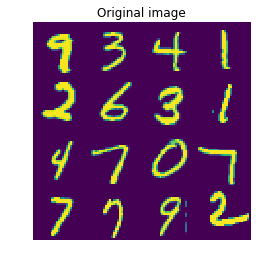

In [21]:
#build an image with severa digits to see the activation map

image = np.zeros((28 * 4, 28 * 4))
batch = x.detach().numpy()
for i in range(4):
    for j in range(4):
        image[i * 28 : (i + 1) * 28, j * 28 : (j + 1) * 28] = x[i * 4 + j, 0]

plt.title("Original image")
plt.imshow(image)
plt.axis("off")
plt.show()

In [22]:
#pass the all convolutionnal network on the image
activation_maps = all_conv(torch.FloatTensor(image).view([1, 1, 28 * 4, 28 * 4])).detach().numpy()

/usr/local/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


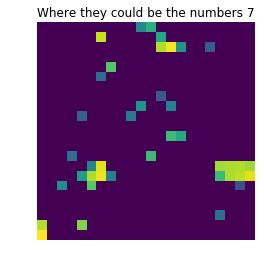

In [23]:
plt.title("Where they could be the numbers 7")
plt.axis("off")
plt.imshow(activation_maps[0, 7] * (activation_maps[0, 7] == activation_maps.max(0).max(0))) #keep only the max responses
plt.show()

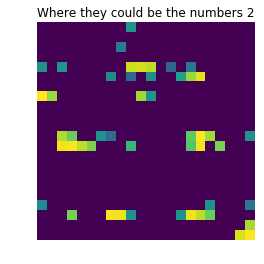

In [24]:
plt.title("Where they could be the numbers 2")
plt.axis("off")
plt.imshow(activation_maps[0, 2] * (activation_maps[0, 2] == activation_maps.max(0).max(0)))
plt.show()

pretty cool no ?

## Autoencoder

Now, let's try a very different thing : let's generate digits from random noise with autoencoder.

Anautoencoder's task is to reproduce in output what i got in input by compressing the data in a latent space.

In [25]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hu_size=[50, 20, 10]):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_size, hu_size)
        self.decoder = Encoder(hu_size[-1], hu_size[::-1][1:] + [input_size], is_decoder=True)
    
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
class Encoder(nn.Module):
    def __init__(self, input_size, hu_size, is_decoder=False):
        super(Encoder, self).__init__()
        L = [input_size] + hu_size
        self.seq = []
        for i in range(len(L) - 1):
            if not is_decoder:
                self.seq.append(nn.Dropout(.25))
            self.seq.append(nn.Linear(L[i], L[i + 1]))
            if not (is_decoder and i == len(L) - 2):
                self.seq.append(nn.ReLU())
        self.seq = nn.Sequential(*self.seq)
    
    def forward(self, x):
        return self.seq(x)

In [26]:
latent_space_size = 100

ae = Autoencoder(784, [500, 200, 200, latent_space_size])
loss_function = nn.MSELoss() 
optimizer = optim.Adam(list(ae.parameters()))

ae

Autoencoder(
  (encoder): Encoder(
    (seq): Sequential(
      (0): Dropout(p=0.25)
      (1): Linear(in_features=784, out_features=500, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.25)
      (4): Linear(in_features=500, out_features=200, bias=True)
      (5): ReLU()
      (6): Dropout(p=0.25)
      (7): Linear(in_features=200, out_features=200, bias=True)
      (8): ReLU()
      (9): Dropout(p=0.25)
      (10): Linear(in_features=200, out_features=100, bias=True)
      (11): ReLU()
    )
  )
  (decoder): Encoder(
    (seq): Sequential(
      (0): Linear(in_features=100, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ReLU()
      (4): Linear(in_features=200, out_features=500, bias=True)
      (5): ReLU()
      (6): Linear(in_features=500, out_features=784, bias=True)
    )
  )
)

In [27]:
ae = ae.train()      
#just one epoch...
for i, (x, y) in enumerate(train_loader):                
    if x.shape[0] != BATCH_SIZE:                         
        continue
    x = x.view([BATCH_SIZE, SIZE * SIZE]).to(DEVICE)  
    y = x.to(DEVICE)                                   
    pred = ae(x) 
    loss = loss_function(pred, y)     
    optimizer.zero_grad()    
    loss.backward()                         
    optimizer.step()      

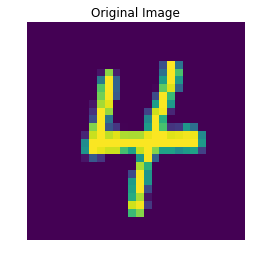

In [28]:
plt.title("Original Image")
plt.imshow(x[2].detach().numpy().reshape(28, 28))
plt.axis("off")
plt.show()

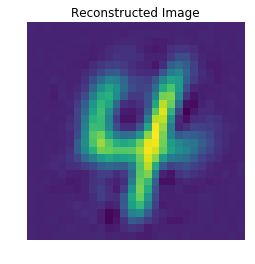

In [29]:
plt.title("Reconstructed Image")
plt.imshow(ae.eval()(x[2].view([1, SIZE * SIZE])).detach().numpy().reshape((28, 28)))
plt.axis("off")
plt.show()

Now let's try to generate a digit by feefing the decoder with random numbers...

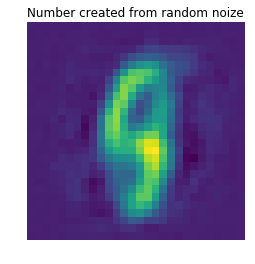

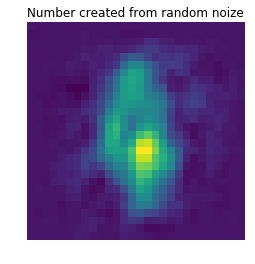

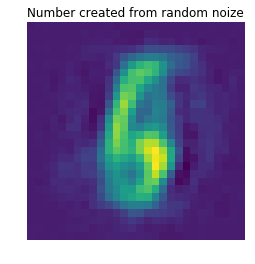

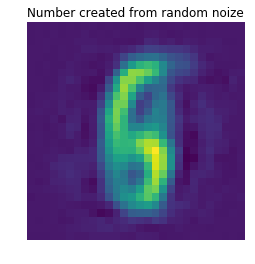

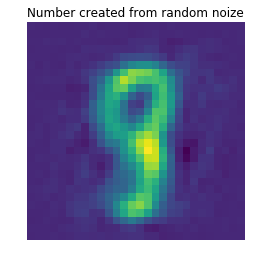

In [30]:
for i in range(5):
    random_input = torch.rand(1, latent_space_size) ** 5 #power just to add more variance... not the best way I know...

    plt.title("Number created from random noize")
    plt.imshow(ae.decoder.eval()(random_input).detach().numpy().reshape((28, 28)))
    plt.axis("off")
    plt.show()

At first look it's not so whahou, but there exists other ways to get better results.
Some other kind of others autoencoders are :

- convolutionnal autoencoder (just autoencoder with convolution)
- denoising autoencoder (remove noise from a noisy image)
- variationnal autoencoder (the best autoencoder for the more realist generated examples)

Autoencoders were found as a good unsupervised way to initialize weights of a network.

___Exercice___: _try to create a simple network upon the encoder part (the encoder will serve as features extractor and should be frozen)_...

## Transfer Learning

Another interting part with the network is that the knowledge they learn (the features) can some times be transferable from one dataset to another.
Also, as two dataset could be similar the features learned from one could also be helpfull on another.

Our lenet like network is composed into two stages : the convolutionnal features extraction, the fully connected classifier.

Here we will replace the fully connected classifier by another one to match the classification task on another dataset and we will keep the convolutionnal features learned.

The new dataset is a subpart of the omniglot dataset, we will try to classify the chars of the Tifinagh alphabet. The chars looks like this :

![c1](./imgs/Tifinagh/character54/0963_13.png)
![c2](./imgs/Tifinagh/character40/0949_04.png)
![c3](./imgs/Tifinagh/character12/0921_04.png)
![c4](./imgs/Tifinagh/character06/0915_03.png)
![c5](./imgs/Tifinagh/character38/0947_07.png)



There are 55 classes (letters) and we only have 20 examples by class !
We will train our classifier on the 15 first chars and test it on the last 5 for each class...
To help avoiding too much overfitting we will also use image augmentation (create new ones by adding small transformations like rotation zoom etc.)

As the dataset is not exacly formated there will be a small preprocessing step and will create a new custom pytorch class...

⚠️ as there is more classes and less example, this task is less simple than MNIST ! generaly we take a network trained on an harder dataset with enought generalization (not the case of MNIST)...

In [31]:
class TifinaghDataset(Dataset):
    def __init__(self, train=True):
        self.train = train
        imgs_path = sorted(glob.glob("./imgs/Tifinagh/*/*.png"))
        if train:
            imgs_path = list(filter(lambda im_path: int(im_path[-6:-4]) <= 15, imgs_path))
        else:
            imgs_path = list(filter(lambda im_path: int(im_path[-6:-4]) > 15, imgs_path))
        self.imgs_path = imgs_path
        self.transform = transforms.Compose(
            (
                [   #some transformation for the training samples
                    #transforms.RandomRotation(15),
                    transforms.CenterCrop(100),
                    
                ] if self.train else []
            ) + [
            transforms.Grayscale(),
            transforms.Resize(28),                     #to get the same size input as the mnis dataset
            transforms.ToTensor(),
            transforms.Lambda(lambda t: 1. - t),
            transforms.Normalize((0.1307,), (0.3081,)) #same normalization values as used in MNIST
        ])
    
    def __getitem__(self, index):
        img = Image.open(self.imgs_path[index])
        lbl = int(self.imgs_path[index].split('Tifinagh/')[1].split('/')[0][-2:]) 
        return self.transform(img), lbl - 1
    
    def __len__(self):
        return len(self.imgs_path)


In [32]:
train_loader = torch.utils.data.DataLoader( 
    TifinaghDataset(train=True),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader( 
    TifinaghDataset(train=False),
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [33]:
kab_net = LeNet(55)


kab_net.conv = le_net.conv #transfert the features learn from mnist
#freeze the conv to not erase them with the first pass of classifier learning...
for p in kab_net.conv.parameters():
    p.requires_grad = False
    
    

#making the classifier non linear to get better performances
kab_net.fc1 = nn.Sequential(
    nn.Linear(135, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
)

kab_net.fc2 = nn.Sequential(
    nn.Linear(64, 55),
    nn.BatchNorm1d(55),
    nn.Softmax()
)
 
kab_net.fc = nn.Sequential(kab_net.fc1, kab_net.fc2) #fully connected contain 2 layers : 1hidden 1output


In [34]:
optimizer = optim.Adam(list(kab_net.fc.parameters()), lr=.001)       #create an optimizer
loss_function = nn.CrossEntropyLoss()                    #create a loss function (multic

/usr/local/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


3.995007963741527	3.973795161527746
3.837632226008995	3.7615618144764618
3.716924686057895	3.6281314036425423
3.6046982185513365	3.5154762127820183
3.504032102285647	3.440103671130012
3.422616766948326	3.401657314861522
3.3785878303004244	3.3930451168733486
3.3308519008112887	3.3712104348575367
3.3033029285131716	3.3350376521839813
3.2644973595937095	3.3231655289145077
3.248381203296138	3.3136503976934097
3.219443952336031	3.3189191818237305
3.207827568054199	3.310023027307847
3.199453639049156	3.3049775151645435
3.200333469054278	3.311623320860021
3.1841139746647253	3.3008595073924347
3.1753651114071118	3.3042620490579044
3.165605077556535	3.2965886733111214
3.1674738584780227	3.2971631919636444
3.1596421447454714	3.2966518121607162


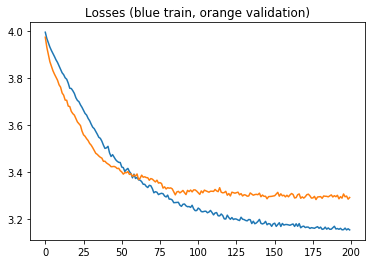

In [35]:
loss_history = []                                          
loss_history_val = []                                       

for epochs in range(200):                                    
    #training
    kab_net = kab_net.train()                    
    mean_loss = 0.                                          
    for i, (x, y) in enumerate(train_loader):               
        if x.shape[0] != BATCH_SIZE:                    
            continue
        x = x.view([BATCH_SIZE, 1, SIZE, SIZE]).to(DEVICE)    
        y = y.to(DEVICE)                                     
        pred = kab_net(x)                               
        loss = loss_function(pred, y)                        
        mean_loss += loss.item()                          
        optimizer.zero_grad()                            
        loss.backward()                                   
        optimizer.step()                                  
    mean_loss /= float(i)                                
    loss_history.append(float(mean_loss))
    if epochs % 10 == 0:
        print(mean_loss, end='\t')
    
    #validation
    kab_net = kab_net.eval()                  
    mean_loss_val = 0.
    for i, (x, y) in enumerate(test_loader):
        if x.shape[0] != BATCH_SIZE:
            continue
        x = x.view([BATCH_SIZE, 1, SIZE, SIZE]).to(DEVICE)
        y = y.to(DEVICE)
        pred = kab_net(x)
        loss = loss_function(pred, y)
        mean_loss_val += loss.item()
    mean_loss_val /= float(i)
    loss_history_val.append(float(mean_loss_val))
    if epochs % 10 == 0:
        print(mean_loss_val)
        
plt.title("Losses (blue train, orange validation)")
plt.plot(loss_history)
plt.plot(loss_history_val)
plt.show()


Now we can even transfert the first fully connected layer knwoledge as input to a much powerfull classifier ! 

In [36]:
class KabNetFeatExtractor(nn.Module):
    def __init__(self):
        super(KabNetFeatExtractor, self).__init__()
        self.conv   = kab_net.conv
        self.linear = kab_net.fc1
        
    def forward(self, x):
        out = self.conv(x)
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        return out

In [37]:
kab_net_features_extractor = KabNetFeatExtractor()
kab_net_features_extractor

KabNetFeatExtractor(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 15, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=135, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [38]:
train_loader_all_dataset = torch.utils.data.DataLoader( 
    TifinaghDataset(train=True),
    batch_size=len(TifinaghDataset(train=True)),
    shuffle=True
)

test_loader_all_dataset = torch.utils.data.DataLoader( 
    TifinaghDataset(train=False),
    batch_size=len(TifinaghDataset(train=False)),
    shuffle=True
)

In [39]:
#just get all the dataset...
for x_train, y_train in train_loader_all_dataset:
    pass

for x_test, y_test in test_loader_all_dataset:
    pass

In [40]:
x_features_train = kab_net_features_extractor(x_train)
x_features_test  = kab_net_features_extractor(x_test)


x_features_train = x_features_train.detach().numpy()
x_features_test  = x_features_test.detach().numpy()

In [41]:
clf = RandomForestClassifier(500)
clf.fit(x_features_train, y_train.detach().numpy())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
print(
    "accuracy : ",
    sum(clf.predict(x_features_test) == y_test.detach().numpy()) / len(x_features_test)
) #on 55 classes !!! :) pretty cool non ??!!

accuracy :  0.8036363636363636


Let's compare with a simple random forest without features extraction process...

In [43]:
clf_n = RandomForestClassifier(500)
clf_n.fit(x_train.view(x_train.shape[0], -1).detach().numpy(), y_train.detach().numpy())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
sum(clf_n.predict(x_test.view(x_test.shape[0], -1).detach().numpy()) == y_test.detach().numpy()) / len(x_features_test)

0.6436363636363637

It's seems we got a pretty good improvment no ? and all the convolutions features extraction come from a different dataset !!!
Whaou !!!

___Exercice___: _try to make a 2D visualisation (scatter plot) with the extracted features and add them a color by class to see how it spread (try PCA and TSNE - both in sklearn)_